## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error


np.random.seed(42)

#Import train and test dataset
train = pd.read_csv("train.csv",nrows=10000000)
test = pd.read_csv("test.csv")
train.tail(10)

#Since the missing values is just tiny part of the whole data, we drop them all
train = train.dropna()

#drop the negative amount since it doesn't make sense.
train = train.drop(train[train['fare_amount']<0].index, axis=0)

#drop the passenger amount which is larger than 5(each car can take 5 as maximum)
train = train.drop(train[train['passenger_count']>5].index, axis = 0)

#We can calulate the distance in a sphere when latitudes and longitudes are given by Haversine formula
def haversine_distance(lat1, long1, lat2, long2):
    data = [train]
    for i in data:
        R = 6371  #radius of earth in kilometers
        #R = 3959 #radius of earth in miles
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
    
        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
    
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        #d = R*c
        d = (R * c) #in kilometers
        i['H_Distance'] = d
    return d

haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

#latitude should between -90 to 90; Longitude should between -180 to 180. pick those are in this range.
train = train.drop(train[(train['pickup_latitude']<-90)|(train['pickup_latitude']>90)].index, axis=0)
train = train.drop(train[(train['pickup_longitude']<-180)|(train['pickup_longitude']>180)].index, axis=0)
train = train.drop(train[(train['dropoff_latitude']<-90)|(train['dropoff_latitude']>90)].index, axis=0)
train = train.drop(train[(train['dropoff_longitude']<-180)|(train['dropoff_longitude']>180)].index, axis=0)

scale_l = [-74.1,-73.7, 40.55, 40.90]
n = 10
train = train.drop(train[(train['pickup_latitude']<scale_l[2])|(train['pickup_latitude']>scale_l[3])].index, axis=0)
train = train.drop(train[(train['pickup_longitude']<scale_l[0])|(train['pickup_longitude']>scale_l[1])].index, axis=0)
train = train.drop(train[(train['dropoff_latitude']<scale_l[2])|(train['dropoff_latitude']>scale_l[3])].index, axis=0)
train = train.drop(train[(train['dropoff_longitude']<scale_l[0])|(train['dropoff_longitude']>scale_l[1])].index, axis=0)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()


train['pickup_longitude_range'] = le.fit_transform(pd.cut(train['pickup_longitude'], n))
train['pickup_latitude_range'] = le.fit_transform(pd.cut(train['pickup_latitude'], n))
train['dropoff_longitude_range'] = le.fit_transform(pd.cut(train['dropoff_longitude'], n))
train['dropoff_latitude_range'] = le.fit_transform(pd.cut(train['dropoff_latitude'], n))

train = train.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis = 1)

train['pickup_datetime'] = pd.to_datetime(arg=train['pickup_datetime'], infer_datetime_format=True)


def add_new_date_time_features(dataset):
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['year'] = dataset.pickup_datetime.dt.year
    dataset['day_of_week'] = dataset.pickup_datetime.dt.dayofweek
    return dataset

train = add_new_date_time_features(train)

train.drop(['key'], axis=1, inplace=True)
train.drop(['pickup_datetime'], axis=1, inplace=True)



y = train.pop('fare_amount')

train.head()


,passenger_count,H_Distance,pickup_longitude_range,pickup_latitude_range,dropoff_longitude_range,dropoff_latitude_range,hour,day,month,year,day_of_week
0,1,1.030764,6,4,6,4,17,15,6,2009,0
1,1,8.450134,2,4,3,6,16,5,1,2010,1
2,2,1.389525,2,6,2,5,0,18,8,2011,3
3,1,2.799270,2,5,2,5,4,21,4,2012,5
4,1,1.999157,3,6,3,6,7,9,3,2010,1


## LightGBM

In [26]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.1, random_state=42)
lgb_X_train, lgb_X_test, lgb_y_train, lgb_y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
lgb_train = lgb.Dataset(lgb_X_train, lgb_y_train)
lgb_eval = lgb.Dataset(lgb_X_test, lgb_y_test, reference=lgb_train)
# Define hyperparameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_leaves': 64,
    'max_depth': 15,
    'min_data_in_leaf': 300,
    'learning_rate': 0.01,
    'metric': {'l1', 'l2_root'},
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

lgbm = lgb.train(params, lgb_train, 
                 num_boost_round = 2000,
                 valid_sets = lgb_eval,
                 early_stopping_rounds = 150,
                 verbose_eval = 50, 
                 categorical_feature = ['pickup_longitude_range', 
                                        'pickup_latitude_range', 
                                        'dropoff_longitude_range', 
                                        'dropoff_latitude_range'
                                       ]
                 )

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['dropoff_latitude_range', 'dropoff_longitude_range', 'pickup_latitude_range', 'pickup_longitude_range']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 150 rounds.
[50]	valid_0's rmse: 6.37109	valid_0's l1: 4.03471
[100]	valid_0's rmse: 4.94873	valid_0's l1: 3.02531
[150]	valid_0's rmse: 4.25856	valid_0's l1: 2.47205
[200]	valid_0's rmse: 3.94253	valid_0's l1: 2.18265
[250]	valid_0's rmse: 3.79463	valid_0's l1: 2.02501
[300]	valid_0's rmse: 3.71891	valid_0's l1: 1.94187
[350]	valid_0's rmse: 3.67496	valid_0's l1: 1.89219
[400]	valid_0's rmse: 3.64744	valid_0's l1: 1.86055
[450]	valid_0's rmse: 3.62729	valid_0's l1: 1.83903
[500]	valid_0's rmse: 3.61178	valid_0's l1: 1.82304
[550]	valid_0's rmse: 3.60034	valid_0's l1: 1.81169
[600]	valid_0's rmse: 3.59116	valid_0's l1: 1.80329
[650]	valid_0's rmse: 3.58378	valid_0's l1: 1.79616
[700]	valid_0's rmse: 3.57722	valid_0's l1: 1.7906
[750]	valid_0's rmse: 3.57131	valid_0's l1: 1.78549
[800]	valid_0's rmse: 3.5654	valid_0's l1: 1.78064
[850]	valid_0's rmse: 3.56062	valid_0's l1: 1.77665
[900]	valid_0's rmse: 3.55619	valid_0's l1: 1.7733
[950]

In [27]:
from sklearn.metrics import mean_squared_error
y_pred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration)
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 3.546330741687728


## XGBoost

In [5]:
import xgboost as xgb
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test = xgb.DMatrix(X_test, label=y_test)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [25]:
params={'objective':'reg:linear',
        'eval_metric':'rmse',
        'learning_rate': 0.2,
        'max_depth': 6,
        'max_leaves': 0,
        'n_estimators': 100,
        'min_child_weight': 1,
        'gamma': 0,
        'grow_policy': 'lossguide',
        'colsample_bytree': 0.85,
        'min_child_weight': 1,
        'tree_method': 'gpu_hist'}

watchlist = [(xgb_train, 'xgb_train'), (xgb_test, 'xgb_test')]
xgbm = xgb.train(params = params,
                 dtrain = xgb_train,
                 evals = watchlist,
                 num_boost_round = 2000,
                 early_stopping_rounds = 50,
                 verbose_eval = 100) 

[0]	xgb_train-rmse:11.471	xgb_test-rmse:11.4802
Multiple eval metrics have been passed: 'xgb_test-rmse' will be used for early stopping.

Will train until xgb_test-rmse hasn't improved in 50 rounds.
[100]	xgb_train-rmse:3.5834	xgb_test-rmse:3.60189
[200]	xgb_train-rmse:3.53194	xgb_test-rmse:3.57124
[300]	xgb_train-rmse:3.50574	xgb_test-rmse:3.56274
[400]	xgb_train-rmse:3.48689	xgb_test-rmse:3.55798
[500]	xgb_train-rmse:3.47071	xgb_test-rmse:3.5552
[600]	xgb_train-rmse:3.45801	xgb_test-rmse:3.55366
[700]	xgb_train-rmse:3.44586	xgb_test-rmse:3.55211
[800]	xgb_train-rmse:3.4357	xgb_test-rmse:3.55131
Stopping. Best iteration:
[754]	xgb_train-rmse:3.44021	xgb_test-rmse:3.55085



In [11]:
y_pred = xgbm.predict(xgb_test)
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 3.554639878635857


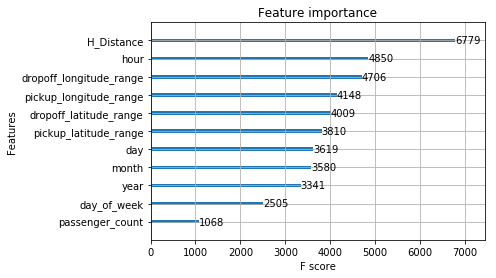

In [22]:
xgb.plot_importance(xgbm, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='F score', ylabel='Features', importance_type='weight', max_num_features=None, grid=True, show_values=True)

## Linear Regression

In [15]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression(n_jobs=-1)
linreg.fit(X_train, y_train)

print("Training score: {:.5f}".format(linreg.score(X_train, y_train)))
print("Testing score: {:.5f}".format(linreg.score(X_test, y_test)))

y_pred = linreg.predict(X_test)

print('The RMSE of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

Training score: 0.77140
Testing score: 0.77119
The RMSE of prediction is: 4.357027676129611


## Ridge Regression

In [14]:
from sklearn.linear_model import RidgeCV

reg_cv = RidgeCV(alphas = [0.001, 0.01, 0.1, 1, 5, 10], cv=5)

reg_cv.fit(X_train, y_train)

print("Training set score: {:.5f}".format(reg_cv.score(X_train, y_train)))
print("Testing set score: {:.5f}".format(reg_cv.score(X_test, y_test)))

y_pred = reg_cv.predict(X_test)

print('The RMSE of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

Training set score: 0.77140
Testing set score: 0.77119
The RMSE of prediction is: 4.357027683901787


## LASSO

In [16]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas = [0.001, 0.01, 0.1, 1, 5, 10], cv=5)

lasso_cv.fit(X_train, y_train)

print("Training set score: {:.5f}".format(lasso_cv.score(X_train, y_train)))
print("Testing set score: {:.5f}".format(lasso_cv.score(X_test, y_test)))

y_pred = lasso_cv.predict(X_test)

print('The RMSE of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

Training set score: 0.77140
Testing set score: 0.77119
The RMSE of prediction is: 4.3570384304403


## Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor

rfreg = RandomForestRegressor(n_jobs=-1)
# n_estimators = 10
# min_samples_split: 2
# min_samples_leaf: 1
# boostrap: True

rfreg.fit(X_train, y_train)

print("Training set score: {:.5f}".format(rfreg.score(X_train, y_train)))
print("Testing set score: {:.5f}".format(rfreg.score(X_test, y_test)))

y_pred = rfreg.predict(X_test)

print('The RMSE of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set score: 0.96677
Testing set score: 0.81927
The RMSE of prediction is: 3.8722403145679527


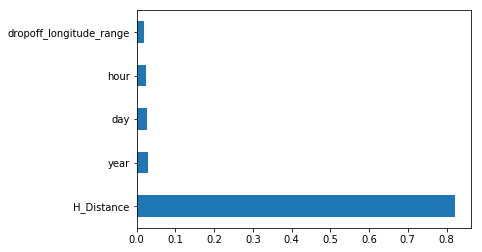

In [20]:
# Feature Importance
feat_importances = pd.Series(rfreg.feature_importances_, index=train.columns)
feat_importances.nlargest(5).plot(kind='barh')